<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/Session3_Pandas_Numpy_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle

# Go on kaggle > Account > Create New API token
# Save the json file in your laptop in a dedicated folder

# copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Datasets available here: 
# https://www.kaggle.com/avikpaul4u/vehicle-loan-default-prediction
!kaggle datasets download -d avikpaul4u/vehicle-loan-default-prediction
!unzip vehicle-loan-default-prediction.zip
# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009
!unzip red-wine-quality-cortez-et-al-2009.zip

Saving kaggle.json to kaggle.json
 77% 9.00M/11.6M [00:00<00:00, 14.5MB/s]
100% 11.6M/11.6M [00:00<00:00, 19.8MB/s]
Archive:  vehicle-loan-default-prediction.zip
  inflating: Data Dictionary.xlsx    
  inflating: test.csv                
  inflating: train.csv               
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 23.7MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


In [2]:
import pandas as pd
import numpy as np
red_wine = pd.read_csv('/content/winequality-red.csv')

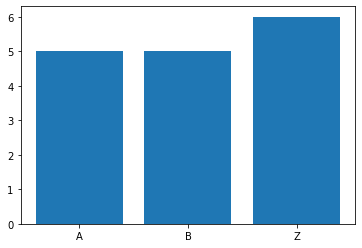

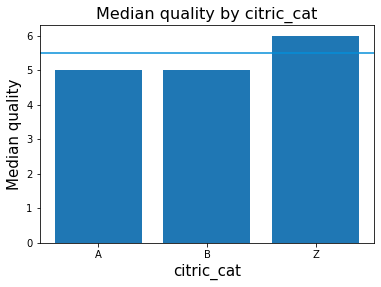

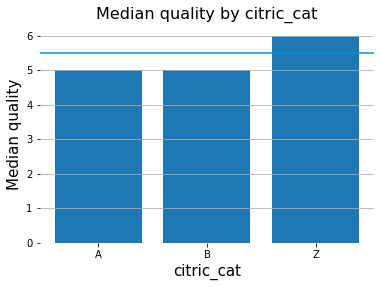

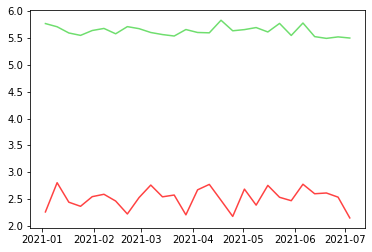

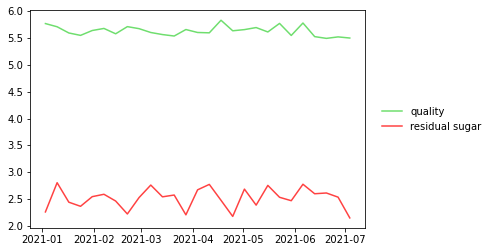

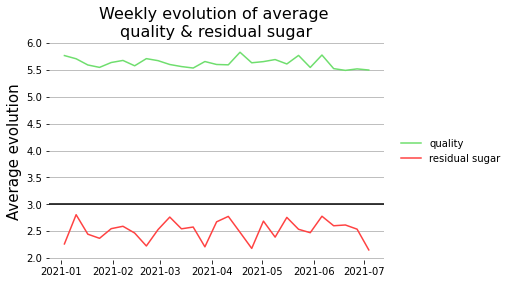

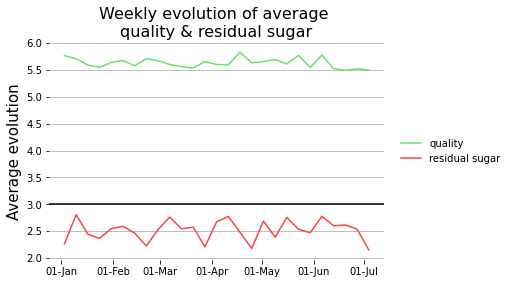

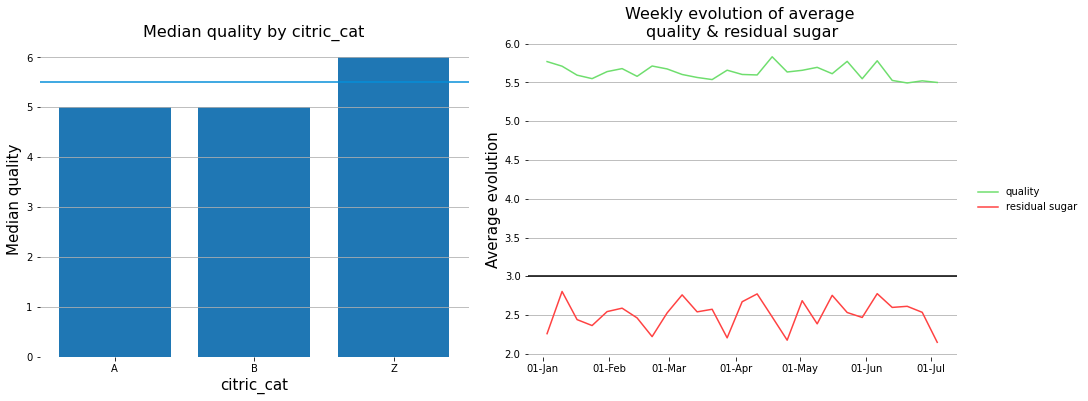

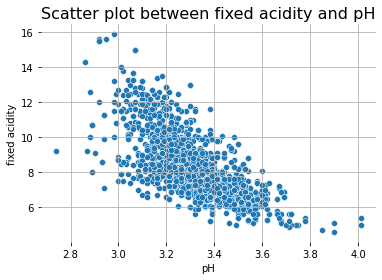

In [3]:
import pandas as pd # Here I import a library named pandas which is specialized in
# data manipulation. I give an alias pd it is a kind of pseudonyme where pd refers to pandas.
import numpy as np
df = pd.read_csv('/content/winequality-red.csv')
# Here I use the function read_csv from the pandas package and I assign it to a database named df.
# There is a lot of possible parameters in the read_csv function: Always check the documentation.
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

def citric_acid_cat(x):
  if x < 0.21 :
    return 'A'
  elif x < 0.3 :
    return 'B'
  else:
    return 'C'

# Now we want to create a new feature citric_cat, which transform the numerical value
# of citric acid to the category defined above for each line of the feature.
# We could create a for loop. However the apply lambda is more efficient from a computing point of view 
# The x refers to the x of the function which is df['citric acid']
df['citric_cat'] = df['citric acid'].apply(lambda x: citric_acid_cat(x))


# Now let's complexify the database in order to have additional work to do later! Not important to understand
# Educational purpose

# Here I create a binary feature who will be used as target
# We use the numpy.where function which is equivalent to a if-then-else statement
# If df['quality'] >= 7 then df['Y']=1, else df['Y']=0
df['Y'] = np.where(df['quality']>= 7, 1, 0)

# We create as well some binary features of 'fixed acidity' & 'volatile acidity'
df['fixed_acidity_cat'] = np.where(df['fixed acidity']<= 8, 0, 1)
df['volatile_acidity_cat'] = np.where(df['volatile acidity']>= 0.4, 0, 1)

# Here I create some duplicates rows: I do a random sample of df and then I concat them at the end of df
temp = df.sample(n=150, random_state=893717398)
df = df.append(temp)
del(temp)
df.reset_index(drop=True, inplace=True)

# Here I create a new feature pH2 from pH where I had some missing values
df['pH2'] = np.where(df['pH'].index %15 ==0, np.nan, df['pH'])

# Here I create a new random feature 'acidity_other' from 'fixed acidity' and I create some missing values
rng = np.random.default_rng(893717398)
df = df.join(pd.Series(rng.normal(df['fixed acidity'].median(),1,len(df)), name='acidity_other'))
df['acidity_other'] = np.where(df['acidity_other'].index %2 !=0, np.nan, df['pH'])

#Here it is a function that will automatically create a feature of random dates between a defined interval
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds 
    (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to 
    the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by 
    the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit)

# Now I apply my function in order to create the new feature 'date'
np.random.seed(893717398)
d_start = pd.to_datetime('2021-01-01')
d_end = pd.to_datetime('2021-06-30')
df['date'] = random_datetimes_or_dates(d_start, d_end, out_format='datetime', n=len(df))
df['date'] = df['date'].astype(str)

## End of the complexification

# Have a look on the etadata of the dataframe:
df.shape
df.dtypes

# Have a look on the describe() function applied to a categorical feature:
df['citric_cat'].describe()

# Let's say that you want to replace the category 'C' by the category 'Z:
df['citric_cat'] = np.where(df['citric_cat'] == 'C', 'Z', df['citric_cat'])
# You could use as well the replace() function from pandas

# One of the most useful function in order to do some counts: value_counts()
df['citric_cat'].value_counts()
df['citric_cat'].value_counts(True)
np.round(df['citric_cat'].value_counts(True)*100, 2)

# Let's see if we have some missing values (NaN for Not a Number) with the function isna():
df.isna()
df.isna().sum() # Sum per column
#df.isna().sum(1) # Sum per rows
# The treatment of missing values for a modeling purpose will be in another session

# Let's parsing some date.
# Parsing a date means to make a date understandable by a computer. Without parsing, it is 
# considered as a chain of character.
df['date'].head(3)
df['date'] = pd.to_datetime(df['date'], format= '%Y-%m-%d %H:%M:%S') # -> ALWAYS specify the format! <-
# For all the existing formats:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

# Now we can work with the date feature in order to create a duration
today = pd.to_datetime('2021-10-12', format = '%Y-%m-%d')
today
df['time_diff'] = today - df['date']
df['time_diff'].head(3)
df.dtypes
# We can as well transform the timedelta in a numerical form:
df['day_diff'] = (df['time_diff']/np.timedelta64(1, 'D')).astype(float)
df['day_diff']

# Now let's pratice some merges
# First, let's create a new database randomf1 & randomf2:
np.random.seed(893717398)
randomf1 = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
randomf2 = pd.Series(np.random.normal(1, 0.5, len(df)), name='Random_Normal_feature2')

# First way to do a merge: Doing a concatenation
# Be careful because it has some limitation!!!!
# You need to be sure at 100% that each rows of the 2 database to concat are referring to the same observation!!
randomf = pd.concat([randomf1, randomf2], axis=1, ignore_index=True)
randomf.columns = ['Random_Normal_feature1', 'Random_Normal_feature2']

# Here I create a a new feature in df that will be used as key:
np.random.seed(893717398)
df['Random_Normal_feature1'] = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')

# Second way to do a merge: Using the merge function:
df = df.merge(randomf, how='inner', on='Random_Normal_feature1')
# Have a look on the documentation to see all the possibilities

# We can easily do some agregations of features through a groupby:
df.groupby('citric_cat')['quality'].mean()
df.groupby(['citric_cat', 'quality'])[['sulphates', 'fixed acidity']].mean()

# Last element very useful in data manipulation is the pivot table:
pd.pivot_table(df, values='sulphates', index=['Y', 'quality'],
                    columns=['citric_cat'], aggfunc=np.mean)
# Go to see the documentation for additional details

# End of the data manipulation part with pandas and numpy !
# Now you have the basis to manipulate every databases and to agregate or to obtain summary statistics


# Let's import new packages:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns

# Bar plot
# Let's represent visually the median wine quality by citric_cat
# First: represent the database:
df_barplot = pd.DataFrame(df.groupby('citric_cat')['quality'].median()).reset_index() # Citric_cat
# is an ordered feature, so we will not change the order in the plot
df_barplot

# We need to define a figure and a Axes:
fig1, ax = plt.subplots() # It always starts like this
# Define the kind of visualization you want, here it's a bar plot
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
plt.show()

# Let's add a horizontal line showing the median -0.5 quality off all wines
med_quality = df['quality'].median() - 0.5

fig1, ax = plt.subplots()
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax.axhline(y=med_quality, color='#058ED9')
ax.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax.set_ylabel('Median quality', fontsize = 15)
ax.set_xlabel('citric_cat', fontsize=15)
plt.show()

# Let's make the plot pretty:
med_quality = df['quality'].median() - 0.5

fig1, ax = plt.subplots()
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax.axhline(y=med_quality, color='#058ED9')

ax.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax.set_ylabel('Median quality', fontsize = 15)
ax.set_xlabel('citric_cat', fontsize=15)

# Add a grid composed only by the y axis
ax.grid(b=True, which='major', axis='y')

# Delete useless visual lines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## We stopped here, please have a look on the following

# Line plot: let's represent the evolution of the average quality and the average residual
# sugar per week:

df_lineplot = df[['date', 'quality', 'residual sugar']].sort_values(by='date')
df_lineplot=df_lineplot.set_index('date').resample('W').mean().reset_index()

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')
plt.show()

# With a legend

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

# Add a legend:
ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)

plt.show()

# Make it pretty

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax.set_ylabel('Average evolution', fontsize=15)

ax.grid(b=True, which='major', axis='y')
ax.axhline(3, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

# Change date display
months=mdates.MonthLocator()
x_display = mdates.DateFormatter('%d-%b')

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax.set_ylabel('Average evolution', fontsize=15)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(x_display)

ax.grid(b=True, which='major', axis='y')
ax.axhline(3, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

# Now let's try to put to plots on the same figure
# You will see the utility of Axes
med_quality = df['quality'].median() - 0.5
months=mdates.MonthLocator()
x_display = mdates.DateFormatter('%d-%b')

fig3 = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig3.add_gridspec(2,2)
ax1 = fig3.add_subplot(gs[0,0])
ax2 = fig3.add_subplot(gs[0,1])

ax1.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax1.axhline(y=med_quality, color='#058ED9')

ax1.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax1.set_ylabel('Median quality', fontsize = 15)
ax1.set_xlabel('citric_cat', fontsize=15)

# Add a grid composed only by the y axis
ax1.grid(b=True, which='major', axis='y')

# Delete useless visual lines:
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


ax2.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax2.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax2.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax2.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax2.set_ylabel('Average evolution', fontsize=15)

ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(x_display)

ax2.grid(b=True, which='major', axis='y')
ax2.axhline(3, color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()


# EVERYTHING IS POSSIBLE with matplotlib
# But it can be difficult to find some intuition about how to do something.
# The solution is to use a cheat sheet and the best can be found here:
# https://github.com/matplotlib/cheatsheets

# Bonus example
# You can use as well seaborn who have built-in plots
# The syntax is simplier and this is a layer of matplotlib
# which means that you can insert seaborn code in a matplotlib figure!!

fig4, ax = plt.subplots()
ax = sns.scatterplot(data=df, x="pH", y="fixed acidity")

ax.set_title('Scatter plot between fixed acidity and pH', loc='center', fontsize=16)

ax.grid(b=True, which='major', axis='both')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()
